# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token:

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen.

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit_gif.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer**

2. **Ingresar y ajustar los parametros del modelo***

3. **Probar diferentes técnicas de data augmentation**

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer



device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_encoding = torch.nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_encoding

# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")


Dispositivo:  cuda
Torch version:  2.5.0+cu121


In [3]:
pos_embeddings.size()


torch.Size([1, 196, 8])

# Transformer Encoder

In [4]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,bias= False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer

| Model       | Layers | Hidden size (D) | MLP size | Heads | Params |
|-------------|--------|-----------------|----------|-------|--------|
| ViT-Base    | 12     | 768             | 3072     | 12    | 86M    |
| ViT-Large   | 24     | 1024            | 4096     | 16    | 307M   |
| ViT-Huge    | 32     | 1280            | 5120     | 16    | 632M   |

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_heads, ff_dim, num_layers, dropout, batch_first, num_classes):
        super(VisionTransformer,self).__init__()

        # Parámetro para el formato de batch
        self.batch_first = batch_first

        #Input: genera patch embeddings a partir de la imagen
        self.pat_emb =  PatchEmbedding(img_size, patch_size, 3, embed_dim)

        # Capa de positional encoding leaarned
        num_patches = (img_size // patch_size) ** 2
        self.pos_emb = PositionalEncodingLearned(num_patches, embed_dim)

        # Transformer Encoder
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)

        # Output: clasificación según la clase
        self.output = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Genera embeddings de los patches
        x = self.pat_emb(x)

        # Aplica el positional encoding
        x = self.pos_emb(x)

        # Pasa las embeddings al encoder
        x = self.transformer_encoder(x)

        # Output: clasificación final
        x = self.output(x[:, 0] if self.batch_first else x[0, :, :])  # Usamos el primer token de la secuencia

        return x



# CIFAR10

## Configuración #1

In [6]:

# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

100%|██████████| 170M/170M [00:05<00:00, 30.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


## Modelo

En este caso quisiera respetar los parámetros de ViT-Base, pero estoy corriendo la notebook en Google-Colab con recursos T4-GPU y tengo limitaciones de memeoria con los parámetros sugeridos, por lo que tuve que reducirlos para poder entrenar el modelo propuesto

In [8]:
num_epochs = 10


model = VisionTransformer(
    img_size=  32, #tamaño de cifar10
    patch_size= 12,
    embed_dim= 128,
    num_heads=  2,
    ff_dim= 256,
    num_layers= 4,
    dropout= 0.1,
    num_classes= 10,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model = model.to(device)


try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


Parametros del modelo: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Parameter containing:
tensor([[[[-3.3752e-02,  3.1411e-02, -1.3089e-02,  ..., -3.2909e-02,
           -5.6123e-03, -3.5668e-02],
          [-4.2608e-04,  1.2558e-02, -2.2294e-02,  ...,  1.3167e-02,
           -1.7766e-02,  5.0877e-03],
          [-4.6586e-03, -1.8353e-02,  2.2565e-02,  ..., -4.1655e-02,
            3.1986e-02,  2.7633e-03],
          ...,
          [ 7.4564e-03,  3.3933e-03,  4.1233e-02,  ...,  4.7658e-02,
           -2.0090e-02,  2.0107e-02],
          [ 1.2185e-02,  4.4511e-02, -9.2188e-03,  ...,  1.4762e-02,
           -4.6377e-02,  3.0928e-03],
          [-1.3751e-02,  1.6961e-02,  3.6360e-02,  ...,  4.1402e-02,
            1.3895e-02,  5.7435e-03]],

         [[ 3.6156e-02, -2.4474e-02,  4.1945e-02,  ...,  4.0517e-02,
           -2.5064e-02, -1.0064e-03],
          [ 3.6110e-02, -2.2936e-02, -2.8469e-02,  ..., -3.0607e-02,
            3.2521e-02,  2.1576e-03],
          [ 2.1233e-02, -3.1678e-02, -1.5997e-02,  ..., -9.0469e-03,
            3.5406e-02,  1.6792e-02

In [9]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 0.58 millones


## Trainer

In [10]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

    #scheduler.step()

  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
loss 1.81176: 100%|██████████| 98/98 [00:36<00:00,  2.72it/s]


## Métricas

In [15]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


In [16]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.35
Precision: 0.36
Recall: 0.35
F1 score: 0.35


In [17]:
train_dataset.data[0].shape

(32, 32, 3)

  0%|          | 0/20 [00:00<?, ?it/s]


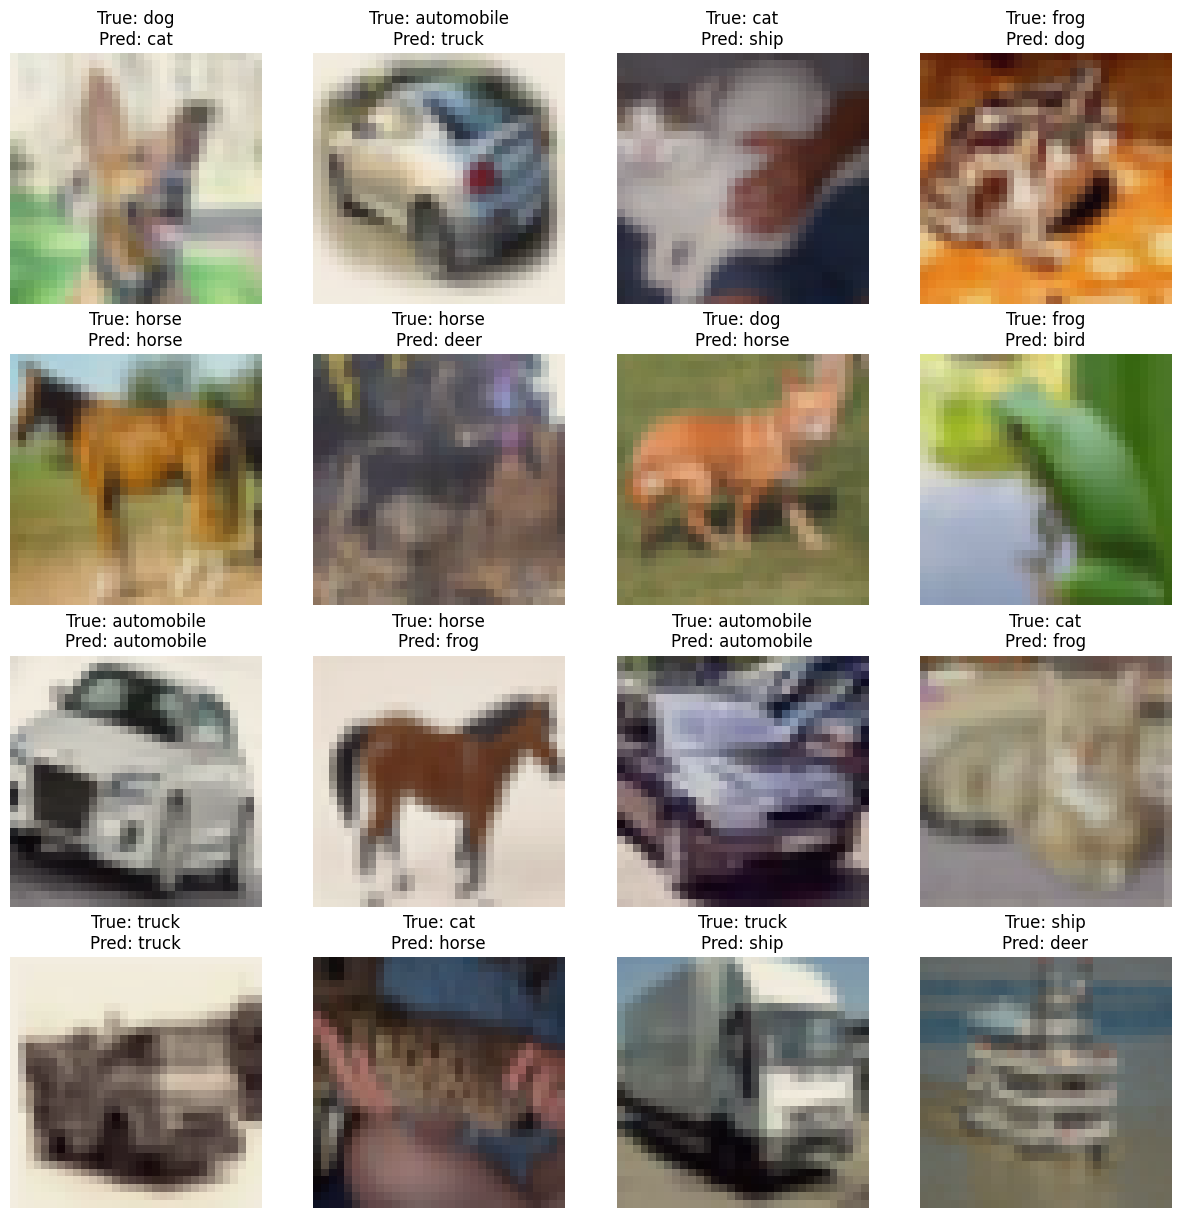

In [18]:
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return


visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()


## Observaciones
PAra este modelo no se pueden aumentar los parámetros de entrenamiento, por limitaciones de recursos; y por eso creo que las métricas no son tan buenas como deberían. Porbablemente disminuyendo la cantidad de clases con estos recursos, o pudiendo entenar con mayores parámetros y epochs, resultarían en mejores resultados

#Cambio en configuración de dataumentation

## Configuración #2

En este caso mantuve los mismos que el anterior pero agregue:

*   **Cambio de parámetros de coloración** (brillo, contraste y saturación) transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
*  **Giro 30'**  transforms.RandomRotation(30)
*  **Rotación vertical** transforms.RandomVerticalFlip()


In [20]:
# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=512, shuffle=True)

test_dataset2 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Modelo

In [21]:
num_epochs = 10


model2 = VisionTransformer(
    img_size=  32, #tamaño de cifar10
    patch_size= 12,
    embed_dim= 128,
    num_heads=  2,
    ff_dim= 256,
    num_layers= 4,
    dropout= 0.1,
    num_classes= 10,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model2.parameters()))

# Definimos funciones de loss y optimizador
criterion2 = nn.CrossEntropyLoss()
optimizer2= optim.AdamW(model2.parameters(), lr=3e-4)
scheduler2 = StepLR(optimizer2, step_size=2, gamma=0.1)


model2 = model2.to(device)


try:
    model2 = torch.compile(model2)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


Parametros del modelo: [Parameter containing:
tensor([[[[ 1.6037e-02, -1.5798e-02,  4.0881e-02,  ..., -2.7952e-02,
           -3.6570e-02,  1.3383e-02],
          [-4.2991e-02, -2.4757e-02, -3.1272e-02,  ..., -3.7307e-04,
           -4.3234e-03, -3.3563e-02],
          [-2.8255e-04, -2.7079e-03,  3.5355e-02,  ...,  3.2789e-03,
            3.4665e-02, -2.0056e-02],
          ...,
          [-3.7766e-02,  2.1457e-02, -1.4061e-02,  ...,  2.6171e-02,
            1.6204e-02,  9.0037e-03],
          [ 2.8590e-02,  2.7411e-02, -3.3507e-02,  ..., -2.2673e-02,
           -1.2676e-02, -1.8497e-02],
          [-1.3228e-02,  2.7326e-02,  3.0106e-02,  ...,  2.5213e-02,
            3.9245e-02, -1.2529e-02]],

         [[-8.1467e-04,  3.4659e-02, -3.3966e-03,  ..., -9.6528e-03,
           -2.0577e-02, -8.0967e-03],
          [-2.9266e-02,  2.7599e-02,  1.7554e-02,  ..., -3.8163e-02,
           -2.7463e-03,  5.9726e-03],
          [-4.3776e-02, -3.8188e-02,  1.0239e-02,  ...,  3.2643e-02,
            

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Trainer

In [22]:
trainer2 = Trainer(model2, train_loader2,test_loader2,criterion2,optimizer2, device)


for epoch in range(num_epochs):

    trainer2.train_model(use_amp=True)

    #scheduler.step()

loss 1.97789: 100%|██████████| 98/98 [01:12<00:00,  1.35it/s]


## Metricas

In [23]:

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model2, test_loader2)

100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


In [24]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.28
Precision: 0.28
Recall: 0.28
F1 score: 0.26


## Visualziación

  0%|          | 0/20 [00:00<?, ?it/s]


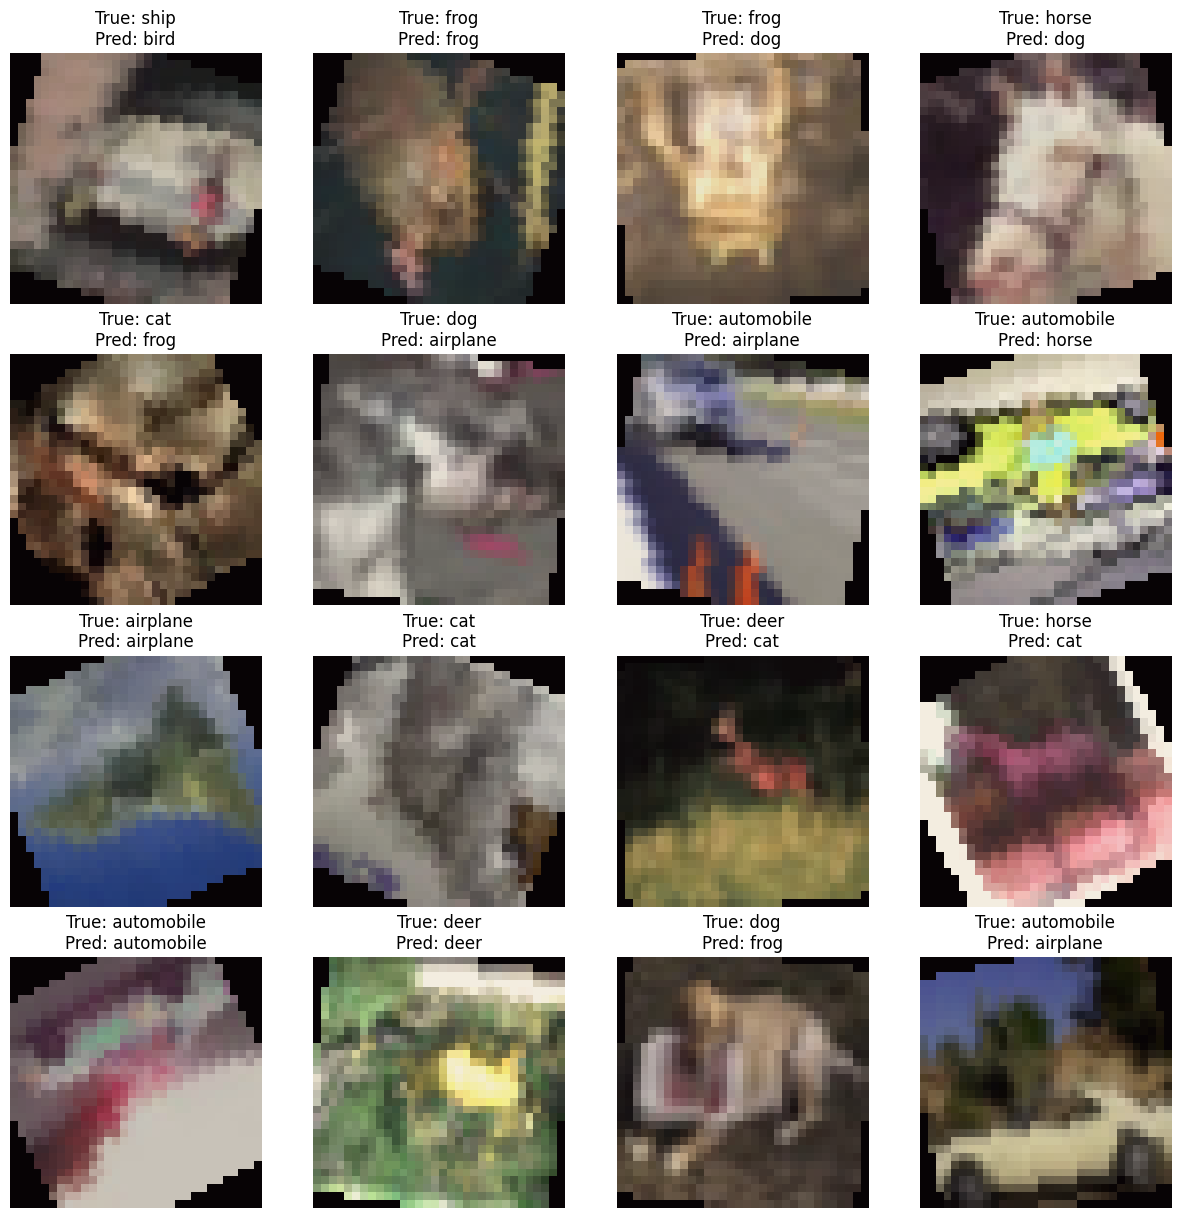

In [25]:
class_names = train_dataset.classes

visualize_classification(model2, test_loader2, class_names, num_images=16)
plt.show()

## Observaciones
En este segundo caso, las métricas del modelo bajaron vs. la primer prueba.  Esto puede deberse al agregado de VerticalFlip, donde el modelo ahora enfrenta imágenes reflejadas verticalmente que podrían no representar patrones comunes en el conjunto de datos de entrenamiento de CIFAR-10.

## Configuración #3
En este caso mantuve los mismos que el #1 pero agregue:

*   **Cambio de parámetros de coloración** (brillo, contraste y saturación) transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
*  **Giro 15'**  transforms.RandomRotation(15)


In [27]:
# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset3 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader3 = torch.utils.data.DataLoader(train_dataset3, batch_size=512, shuffle=True)

test_dataset3 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader3 = torch.utils.data.DataLoader(test_dataset3, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Modelo

In [28]:
num_epochs = 10


model3 = VisionTransformer(
    img_size=  32, #tamaño de cifar10
    patch_size= 12,
    embed_dim= 128,
    num_heads=  2,
    ff_dim= 256,
    num_layers= 4,
    dropout= 0.1,
    num_classes= 10,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model2.parameters()))

# Definimos funciones de loss y optimizador
criterion3 = nn.CrossEntropyLoss()
optimizer3= optim.AdamW(model3.parameters(), lr=3e-4)
scheduler3 = StepLR(optimizer3, step_size=2, gamma=0.1)


model3 = model3.to(device)


try:
    model3 = torch.compile(model3)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0157, -0.0175,  0.0413,  ..., -0.0261, -0.0348,  0.0201],
          [-0.0418, -0.0266, -0.0306,  ...,  0.0048, -0.0016, -0.0354],
          [ 0.0006, -0.0047,  0.0333,  ..., -0.0020,  0.0271, -0.0312],
          ...,
          [-0.0295,  0.0357, -0.0111,  ...,  0.0217,  0.0020, -0.0312],
          [ 0.0335,  0.0423, -0.0315,  ..., -0.0365, -0.0391, -0.0770],
          [-0.0038,  0.0463,  0.0349,  ...,  0.0059,  0.0013, -0.0770]],

         [[-0.0011,  0.0319, -0.0040,  ..., -0.0120, -0.0218, -0.0063],
          [-0.0279,  0.0248,  0.0162,  ..., -0.0432, -0.0079, -0.0002],
          [-0.0436, -0.0416,  0.0048,  ...,  0.0195,  0.0009, -0.0569],
          ...,
          [-0.0194, -0.0387, -0.0182,  ..., -0.0366,  0.0429, -0.0454],
          [ 0.0083,  0.0479,  0.0247,  ...,  0.0191, -0.0542,  0.0139],
          [ 0.0334,  0.0345,  0.0263,  ..., -0.0117, -0.0140, -0.0158]],

         [[-0.0294,  0.0145, -0.0141,  ..., -0.0302, -0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Trainer

In [29]:
trainer3 = Trainer(model3, train_loader3,test_loader3,criterion3,optimizer3, device)


for epoch in range(num_epochs):

    trainer3.train_model(use_amp=True)

    #scheduler.step()

loss 1.86727: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


## Metricas

In [30]:

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model3, test_loader3)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

100%|██████████| 20/20 [00:13<00:00,  1.49it/s]

Accuracy: 0.33
Precision: 0.33
Recall: 0.33
F1 score: 0.32


## Visualización

  0%|          | 0/20 [00:01<?, ?it/s]


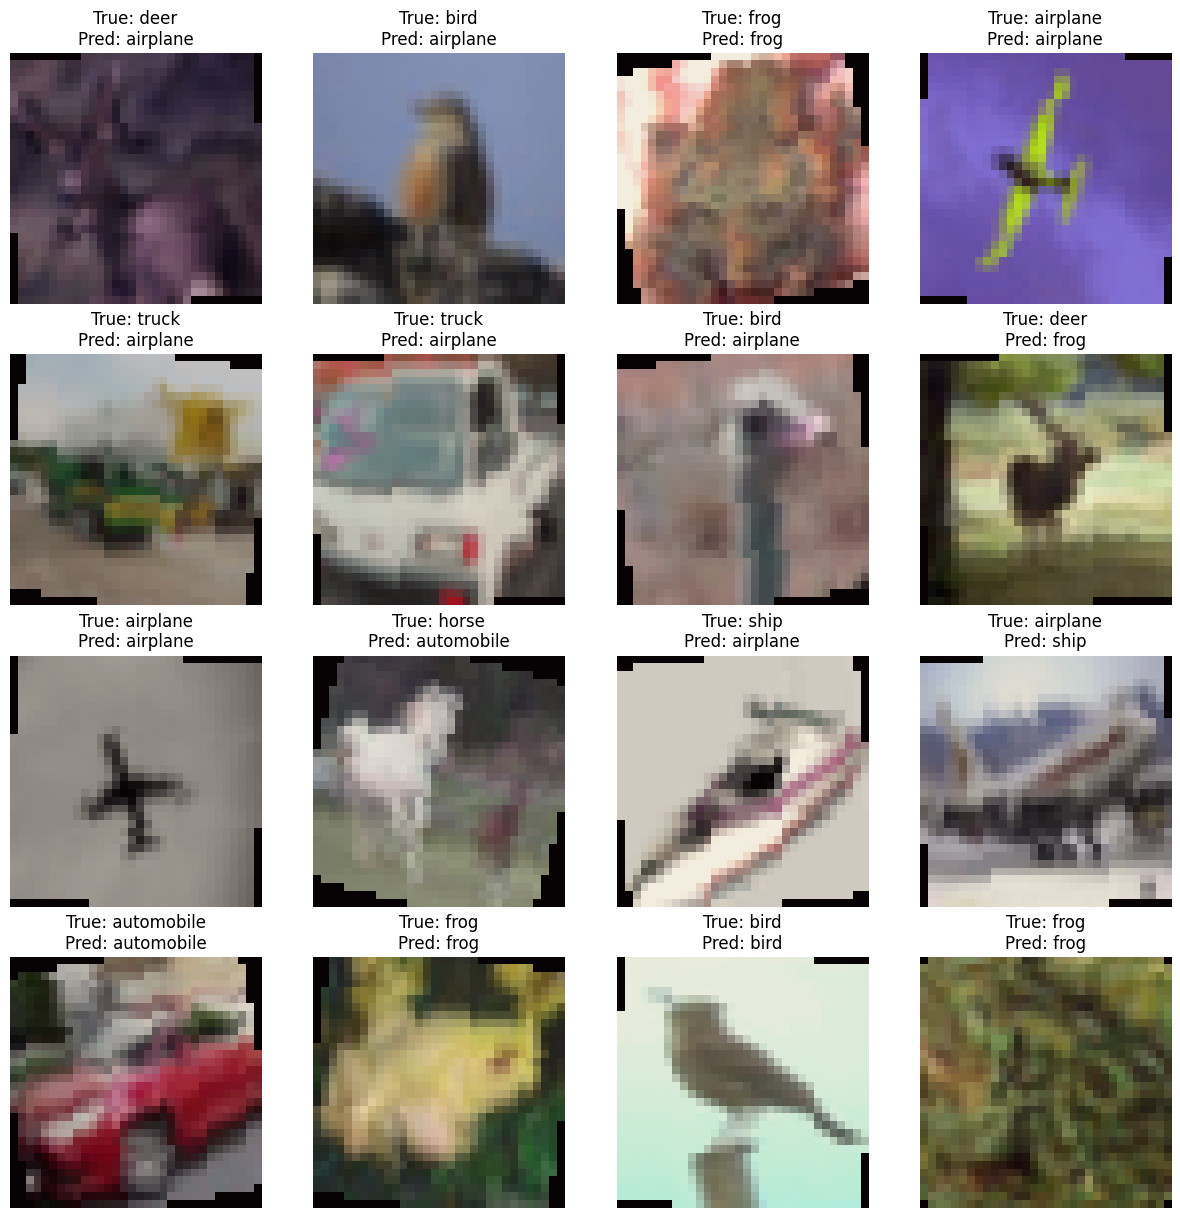

In [31]:
class_names = train_dataset.classes

visualize_classification(model2, test_loader2, class_names, num_images=16)
plt.show()

## Observaciones
En est caso mejoraron las métricas respecto a la #2, por lo que podemos deir que el randomflipvertical no es una transformaci´n adecuada para este dataset; pero aún siguen siendo peor que la configuración #1; por lo que probablmente en este caso las métrcias no influya tanto el Data-augmentation si no, poder variar los parámetros teniendo mayores recursos de procesamiento; y aumentar las epochs de entrenamiento